# 1. Problem Statement

**The objective of this project is to develop a personalized movie recommendation system that enhances user experience by suggesting films tailored to their individual preferences.**

- Current Challenges:

  Information overload: Users face difficulty in navigating and selecting movies from a vast catalog.
  Lack of personalized recommendations: Generic recommendations fail to capture user's specific tastes and interests.

- Proposed Solution:

  This project will build a recommender system utilizing the provided MovieLens dataset (ratings.dat, users.dat, movies.dat). We will explore various recommendation techniques, including:

  - **Collaborative Filtering:**
  User-based filtering: Identify users with similar rating patterns and recommend movies enjoyed by similar users.

  - **Item-based filtering:** Recommend movies similar to those a user has previously rated highly.

  - **Similarity Measures:**
Pearson Correlation Coefficient: Measure the strength of linear relationships between user ratings.

  - **Cosine Similarity:** Evaluate the similarity between users based on the cosine of the angle between their rating vectors.
  - **Matrix Factorization:** Decompose the user-movie rating matrix to uncover latent factors representing user preferences and movie characteristics.

- Evaluation Criteria:

  - **Recommendation Accuracy:** Measure the effectiveness of the system in suggesting movies that users will enjoy, using metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).

  - **User Engagement:** Assess how the system improves user experience by tracking metrics like click-through rates and conversion rates (movies watched based on recommendations).

- Expected Outcome:

  - This project aims to develop a recommender system that delivers personalized movie suggestions, leading to increased user satisfaction and improved user experience on the movie platform.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

# EDA - Exploratory Data Analysis

Formatting data - Movies Table and EDA

In [2]:
# Loading Movies dataset.
movies = pd.read_csv('/content/drive/MyDrive/Data Sets /zee-movies.dat', encoding='latin-1', sep='::', engine='python')

print("shape of original Zee-Movies is:", movies.shape)

movies["Release year"] = movies.Title.str[-5:-1]
movies["Title"] = movies.Title.str[:-7]

movies["Genres"] = movies.Genres.str.replace('"', '')
movies["Movie ID"] = movies["Movie ID"].str.replace('"', '')

movies["Genres"] = movies["Genres"].str.split('|')
movies = movies.explode("Genres")
movies["Movie ID"] = movies["Movie ID"].astype(int)
movies['Release year'] = pd.to_datetime(movies['Release year'], format='%Y').dt.year

movies.rename(columns={'Movie ID': 'MovieID'}, inplace=True)

shape of original Zee-Movies is: (3883, 3)


In [3]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
movies['Release year'] = pd.cut(movies['Release year'], bins=bins, labels=labels)

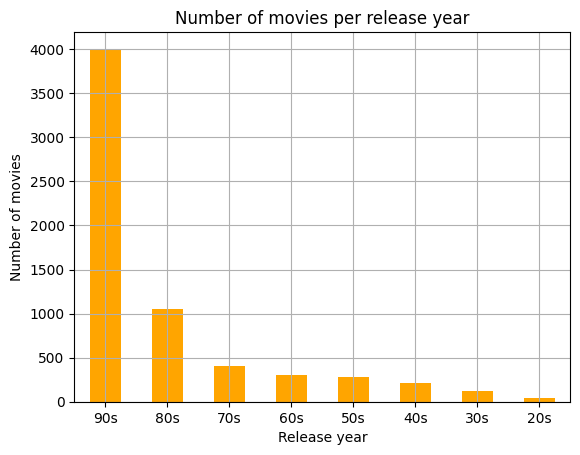

In [4]:
movies.groupby("Release year")["Title"].count().sort_values(ascending=False).plot(kind = "bar",color = "orange")
plt.xlabel("Release year")
plt.ylabel("Number of movies")
plt.xticks(rotation = 0)
plt.title("Number of movies per release year")
plt.grid()
plt.show()

Most of the movies are relased after year 1980

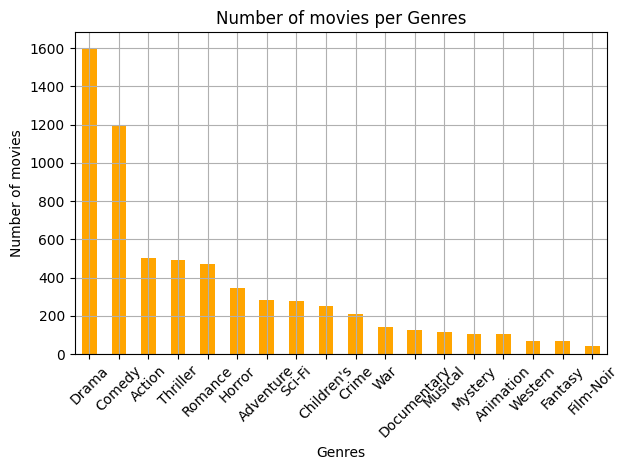

In [5]:
movies.groupby("Genres")["Title"].count().sort_values(ascending=False).plot(kind="bar", color = "orange")
plt.grid()
plt.xlabel("Genres")
plt.xticks(rotation = 45)
plt.ylabel("Number of movies")
plt.title("Number of movies per Genres")

plt.tight_layout()
plt.show()


Most of the movie Genres are Drama, Comedy, Action, Thriller, Romance

Formatting data - Ratings Table and EDA

In [6]:
# Loading ratings dataset.
ratings = pd.read_csv('/content/drive/MyDrive/Data Sets /zee-ratings.dat', encoding='latin-1', sep='::', engine='python')
ratings["MovieID"] = ratings["MovieID"].astype(int)
ratings["UserID"] = ratings["UserID"].astype(int)
ratings["Rating"] = ratings["Rating"].astype(int)
ratings["Timestamp"] = pd.to_datetime(ratings["Timestamp"], unit='s')

r = ratings.copy()


In [7]:
r.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [8]:
print("Average rating of all movies by all users:", ratings["Rating"].mean().round(2))
print("Number of users who provided rating to the movie:", r["UserID"].nunique())
print("Number of rated movies:", r["MovieID"].nunique())

Average rating of all movies by all users: 3.58
Number of users who provided rating to the movie: 6040
Number of rated movies: 3706


# 2. Feature Engineering
Creating features for ratings given by users
1. Rating of each movie - This will help to understand movie rating bias.
2. Average rating of each user - This willl help to understand user rating bias.

This is done using transform method to maintain shape of the data

Feature **Avg_rating_movie_count**:
- Number of ratings considered for finding average rating of movie

In [9]:
r["Avg_rating_movie"] = r.groupby('MovieID')['Rating'].transform('mean')
r["Avg_rating_movie_count"] = r.groupby('MovieID')['Rating'].transform('count')
r["Avg_rating_user"] = r.groupby("UserID")['Rating'].transform('mean')

Using timestamp of rating we may create following features:

Hour of the Day: This can reveal patterns in rating behavior throughout the day. For example, are there peak rating times?

Time Intervals: Creating custom time intervals (e.g., morning, afternoon,  evening,late Night)

In [10]:
r["Timestamp_hour"] = r["Timestamp"].dt.hour

def categorize_hour(hour):
  if 0 <= hour < 6:
    return 'Late Night'
  elif 6 <= hour < 12:
    return 'Morning'
  elif 12 <= hour < 18:
    return 'Afternoon'
  else:
    return 'Evening'

r['timestamp_of_day'] = r['Timestamp_hour'].apply(categorize_hour)

Q. Is there are significant difference in user giving rating to the movies basesd of time of the day?


Text(0, 0.5, 'Average rating')

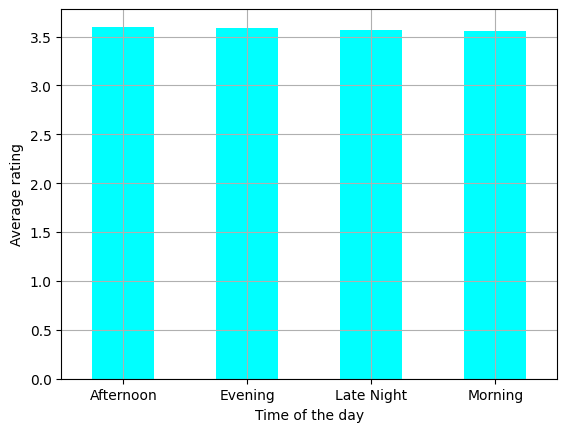

In [11]:
r.groupby("timestamp_of_day")["Rating"].mean().sort_values(ascending=False).plot(kind="bar", color = "cyan")
plt.grid()
plt.xlabel("Time of the day")
plt.xticks(rotation = 0)
plt.ylabel("Average rating")

There is no significant difference in ratings based on Time of the day same for the Hour of the day similary there is not significant change in ratings for hour of the day also. So we may drop these features.


In [12]:
r.drop(['Timestamp_hour',	"timestamp_of_day"], axis = 1, inplace = True)

Formating data- Users Table and EDA

In [13]:
users= pd.read_csv('/content/drive/MyDrive/Data Sets /zee-users.dat', encoding='latin-1', sep='::', engine='python')

u = users.copy()
u.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


Count of ranting by Gender

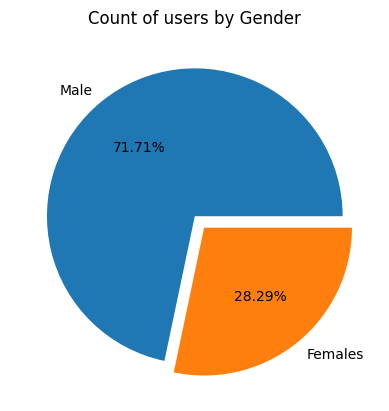

In [14]:
plt.pie(u.Gender.value_counts(normalize = True)*100, labels = ["Male", "Females"], autopct = '%1.2f%%', explode = [0, 0.1])
plt.title("Count of users by Gender")
plt.show()

There are 71% males users.

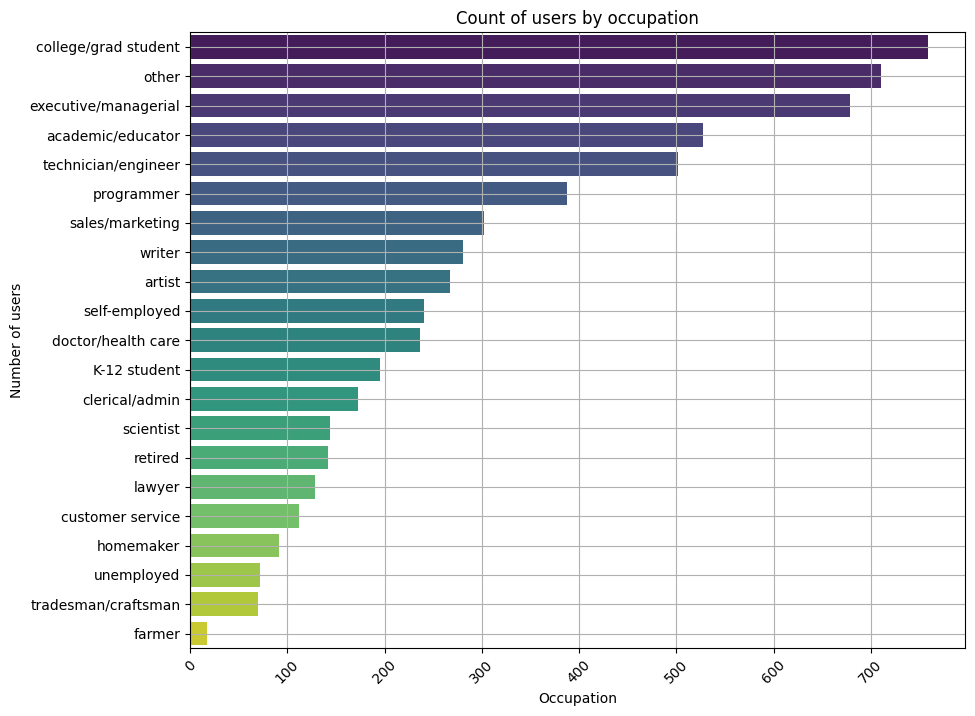

In [15]:
mapping = {0: "other", 1: "academic/educator", 2: "artist", 3: "clerical/admin", 4: "college/grad student", 5: "customer service",
6: "doctor/health care", 7: "executive/managerial", 8: "farmer", 9: "homemaker", 10: "K-12 student", 11: "lawyer", 12: "programmer"
,13: "retired", 14: "sales/marketing", 15: "scientist", 16: "self-employed", 17: "technician/engineer", 18: "tradesman/craftsman"
, 19: "unemployed", 20: "writer"}

u["Occupation_"] = u['Occupation'].map(mapping)

# u.groupby("Occupation_")["UserID"].count().sort_values(ascending=False).plot(kind="bar", color = "orange")
plt.figure(figsize = (10,8))
sns.barplot(y = u.groupby("Occupation_")["UserID"].count().sort_values(ascending=False).index, x = u.groupby("Occupation_")["UserID"].count().sort_values(ascending=False).values, palette = "viridis")
plt.grid()
plt.title("Count of users by occupation")
plt.xlabel("Occupation")
plt.xticks(rotation = 45)
plt.ylabel("Number of users")
plt.show()


In [16]:
print("Number of uniques cities from where entire user base is:",u["Zip-code"].nunique(),)

Number of uniques cities from where entire user base is: 3439


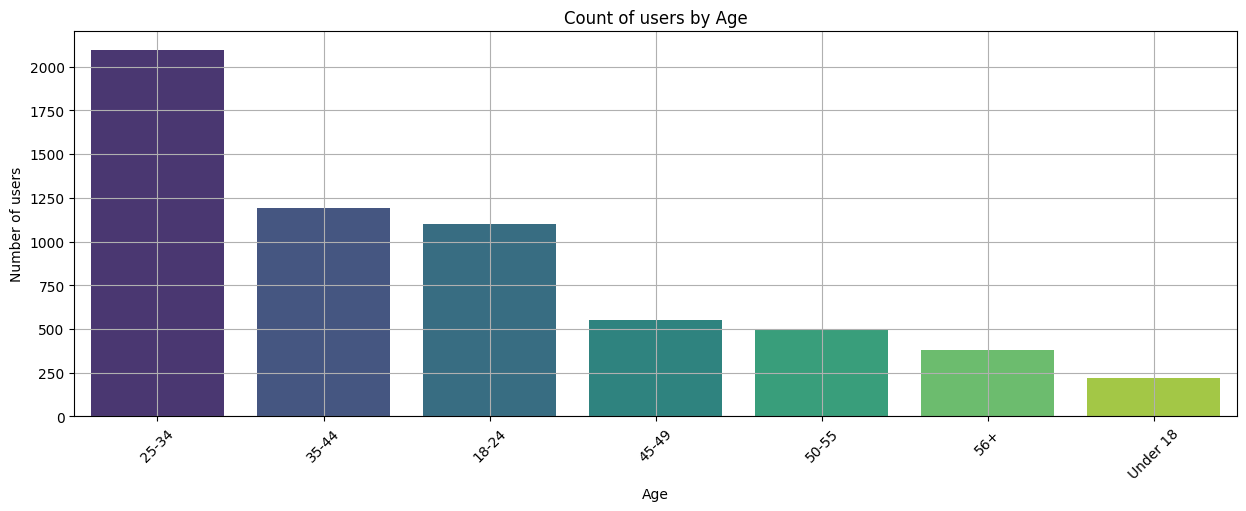

In [17]:
mapping = {1: "Under 18",18: "18-24",25: "25-34",35: "35-44",45: "45-49" ,50: "50-55", 56: "56+"}

u["Age_"] = u['Age'].map(mapping)

plt.figure(figsize = (15,5))
sns.barplot(x = u.groupby("Age_")["UserID"].count().sort_values(ascending=False).index, y = u.groupby("Age_")["UserID"].count().sort_values(ascending=False), palette = "viridis")
plt.grid()
plt.title("Count of users by Age")
plt.xlabel("Age")
plt.xticks(rotation = 45)
plt.ylabel("Number of users")
plt.show()

u.drop("Age", axis = 1, inplace = True)

In [18]:
rm = r.pivot(index= 'UserID', columns = "MovieID", values = "Rating").fillna(0).copy()
print(round(rm[rm > 0].isna().sum().sum()/rm.size, 4)*100, "% values are filled by ratings --> sparse matrix")

95.53 % values are filled by ratings --> sparse matrix


# Merging the data files and creating a single consolidated dataframe

In [19]:
merged_df = r.merge(u, on="UserID", how='inner').merge(movies, on=["MovieID"], how='inner')
merged_df.head(2)

,UserID,MovieID,Rating,Timestamp,Avg_rating_movie,Avg_rating_movie_count,Avg_rating_user,Gender,Occupation,Zip-code,Occupation_,Age_,Title,Genres,Release year
0,1,1193,5,2000-12-31 22:12:40,4.390725,1725,4.188679,F,10,48067,K-12 student,Under 18,One Flew Over the Cuckoo's Nest,Drama,70s
1,2,1193,5,2000-12-31 21:33:33,4.390725,1725,3.713178,M,16,70072,self-employed,56+,One Flew Over the Cuckoo's Nest,Drama,70s


In [20]:
merged_df.shape

(2101815, 15)

In [21]:
merged_df.info()

merged_df["UserID"] = merged_df["UserID"].astype(object)
merged_df["MovieID"] = merged_df["MovieID"].astype(object)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2101815 entries, 0 to 2101814
Data columns (total 15 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   UserID                  int64         
 1   MovieID                 int64         
 2   Rating                  int64         
 3   Timestamp               datetime64[ns]
 4   Avg_rating_movie        float64       
 5   Avg_rating_movie_count  int64         
 6   Avg_rating_user         float64       
 7   Gender                  object        
 8   Occupation              int64         
 9   Zip-code                object        
 10  Occupation_             object        
 11  Age_                    object        
 12  Title                   object        
 13  Genres                  object        
 14  Release year            category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(5), object(6)
memory usage: 226.5+ MB


Dropping Timestamp and Release year columns as they are date tim

In [22]:
merged_df.drop(["Timestamp"], axis = True, inplace = True)

In [23]:
merged_df["Gender"]= merged_df["Gender"].map({"F": 0, "M": 1})


In [24]:
merged_df.describe().round(2)

,Rating,Avg_rating_movie,Avg_rating_movie_count,Avg_rating_user,Gender,Occupation
count,2101815.00,2101815.00,2101815.00,2101815.00,2101815.00,2101815.00
mean,3.58,3.58,927.58,3.58,0.76,8.08
std,1.12,0.54,711.43,0.44,0.43,6.52
min,1.00,1.00,1.00,1.02,0.00,0.00
25%,3.00,3.26,381.00,3.32,1.00,2.00
50%,4.00,3.67,751.00,3.62,1.00,7.00
75%,4.00,3.98,1254.00,3.88,1.00,14.00
max,5.00,5.00,3428.00,4.96,1.00,20.00


In [25]:
merged_df.describe(include = object).round(2)

,UserID,MovieID,Zip-code,Occupation_,Age_,Title,Genres
count,2101815,2101815,2101815,2101815,2101815,2101815,2101815
unique,6040,3706,3439,21,7,3664,18
top,4169,1196,94110,college/grad student,25-34,Star Wars: Episode V - The Empire Strikes Back,Comedy
freq,4006,14950,7814,277745,831332,14950,356580


In [26]:
merged_df.drop_duplicates(inplace = True)
merged_df.dropna(inplace = True)

# 3. Building a Recommender System based on Pearson Correlation

Take a movie name as input from the user

Recommend 5 similar movies based on Pearson Correlation


**Item-Item based operation:**

In [27]:
matrix = pd.pivot_table(merged_df, values='Rating', index='UserID', columns='Title')
matrix.fillna(0, inplace=True)
matrix.head(2)

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Funtion to get top 5 similar movies by person correlation

In [28]:
def pearson_recommender(data = matrix.head(1000), movie_name = "Liar Liar"):

    movie_rating = data[movie_name]
    similar_movies = data.corrwith(movie_rating)
    sim_ = pd.DataFrame(similar_movies, columns=['Correlation'])

    return sim_.sort_values('Correlation', ascending=False)[1:6]

pearson_recommender()

,Correlation
Title,
Mrs. Doubtfire,0.514236
Dumb & Dumber,0.485996
"Wedding Singer, The",0.472575
"Mask, The",0.459419
Ace Ventura: Pet Detective,0.449285


# **4.Building a Recommender System based on Cosine Similarity.**

Print the item similarity matrix and user similarity matrix

Item Item cosine similarity

In [29]:
def Item_cosine_similarity(data = matrix):
  data = data.T
  item_matrix = cosine_similarity(data)
  df =  pd.DataFrame(item_matrix, index=data.index, columns=data.index)
  return df

Item_cosine_similarity().head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


User User Cosine similarity


In [30]:
k = Item_cosine_similarity()
Movie_name = "Liar Liar"

k.sort_values(by = Movie_name, ascending = False)[Movie_name][1:6]

,Liar Liar
Title,
Mrs. Doubtfire,0.557067
Ace Ventura: Pet Detective,0.516861
Dumb & Dumber,0.512585
Home Alone,0.511204
Wayne's World,0.499368


In [31]:
def User_cosine_similarity(data = matrix):
  item_matrix = cosine_similarity(data)
  df =  pd.DataFrame(item_matrix, index=data.index, columns=data.index)
  return df

User_cosine_similarity().head(3)

UserID,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.096382,0.120610,0.132455,0.090158,0.179222,0.059678,0.138241,0.226148,0.254736,...,0.170588,0.082006,0.090961,0.033663,0.114877,0.187179,0.136556,0.000000,0.174604,0.133590
2,0.096382,1.000000,0.151479,0.171176,0.114394,0.100865,0.305787,0.211120,0.190198,0.227745,...,0.112503,0.091222,0.268565,0.014286,0.183384,0.229283,0.207150,0.066118,0.066457,0.218276
3,0.120610,0.151479,1.000000,0.151227,0.062907,0.074603,0.138332,0.077656,0.126457,0.214487,...,0.092960,0.125864,0.161507,0.000000,0.097308,0.143918,0.108202,0.120234,0.094675,0.133144


item Recommendation using Cosine similarity

In [32]:
from scipy import sparse

csr_mat = sparse.csr_matrix(matrix.T.values)
print(csr_mat)

  (0, 215)	2.0
  (0, 493)	5.0
  (0, 713)	4.0
  (0, 868)	1.0
  (0, 1033)	3.0
  (0, 1110)	5.0
  (0, 1140)	4.0
  (0, 1555)	3.0
  (0, 1634)	2.0
  (0, 1644)	5.0
  (0, 1679)	3.0
  (0, 1708)	5.0
  (0, 1747)	1.0
  (0, 1940)	4.0
  (0, 1979)	3.0
  (0, 1997)	3.0
  (0, 2029)	2.0
  (0, 2155)	3.0
  (0, 2254)	3.0
  (0, 2461)	2.0
  (0, 3270)	3.0
  (0, 3291)	2.0
  (0, 3299)	4.0
  (0, 3390)	2.0
  (0, 3664)	4.0
  :	:
  (3660, 5663)	4.0
  (3660, 5674)	3.0
  (3660, 5683)	5.0
  (3660, 5684)	3.0
  (3660, 5701)	4.0
  (3660, 5722)	3.0
  (3660, 5729)	1.0
  (3660, 5748)	4.0
  (3660, 5754)	2.0
  (3660, 5766)	2.0
  (3660, 5787)	4.0
  (3660, 5791)	3.0
  (3660, 5794)	1.0
  (3660, 5796)	3.0
  (3660, 5824)	3.0
  (3660, 5868)	4.0
  (3660, 5885)	4.0
  (3660, 5915)	2.0
  (3660, 5939)	4.0
  (3660, 5952)	4.0
  (3660, 5960)	4.0
  (3660, 5963)	5.0
  (3660, 6000)	4.0
  (3660, 6015)	4.0
  (3660, 6035)	2.0


In [33]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(n_neighbors=6, metric='cosine')
model.fit(matrix.T)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [34]:
def Movie_recommendation_NNeighbours(movie_name):
  distance, titles =  model.kneighbors([matrix.T.loc[movie_name].values])
  return pd.DataFrame({"Title":matrix.T.index[titles[0]], "Distance": distance[0]})[1:]

Movie_recommendation_NNeighbours("Liar Liar")

,Title,Distance
1,Mrs. Doubtfire,0.442933
2,Ace Ventura: Pet Detective,0.483139
3,Dumb & Dumber,0.487415
4,Home Alone,0.488796
5,Wayne's World,0.500632


In [35]:
ratings.shape

(1000209, 4)

In [36]:
rm = (ratings.drop("Timestamp", axis = 1))

In [37]:
rm.columns = ['UserId', 'ItemId', 'Rating']

# 5. Building a Recommender System based on Matrix Factorization.

In [38]:
pip install cmfrec


  Using cached cmfrec-3.5.1.post10.tar.gz (268 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached findblas-0.1.26.post1-py3-none-any.whl
  Created wheel for cmfrec: filename=cmfrec-3.5.1.post10-cp310-cp310-linux_x86_64.whl size=5669622 sha256=a939b2ee1bb73cacebb399c9e833adc6a412678ffe85e7953c5ae0bb79bf0225
  Stored in directory: /root/.cache/pip/wheels/cc/80/d7/9b7d9361970eb499c0227a3fac504240f7793dec0d9793bee6
Successfully built cmfrec


In [39]:
from cmfrec import CMF

model = CMF(method="als", k=4, lambda_=0.1, user_bias=False, item_bias=False, verbose=False)
model.fit(rm)

Collective matrix factorization model
(explicit-feedback variant)


In [40]:
model.A_.shape, model.B_.shape

((6040, 4), (3706, 4))

In [41]:
print("Original Ratings mean:", ratings.Rating.mean())
print("Predicted Ratings mean:", model.glob_mean_)

Original Ratings mean: 3.581564453029317
Predicted Ratings mean: 3.581564426422119


In [42]:
Actual_matrix = rm.pivot(index= 'UserId', columns = "ItemId", values = "Rating")

Predicted_matrix = np.dot(model.A_, model.B_.T)
Predicted_matrix = Predicted_matrix + model.glob_mean_

Actual = Actual_matrix.values[Actual_matrix>0]
Predicted = Predicted_matrix[Actual_matrix>0]

mapping = merged_df[["MovieID", "Title"]].drop_duplicates().set_index("MovieID").to_dict()
Actual_matrix.columns = Actual_matrix.columns.map(mapping["Title"])

In [43]:
# mean square error from sklearn
from sklearn.metrics import mean_squared_error
print("RMSE:", mean_squared_error(Actual, Predicted)**(0.5))

RMSE: 1.3451500957006446


In [44]:
# MAPE
Mape = np.mean(np.abs((Actual - Predicted) / Actual))
print("MAPE:", Mape)

MAPE: 0.37818748754790316


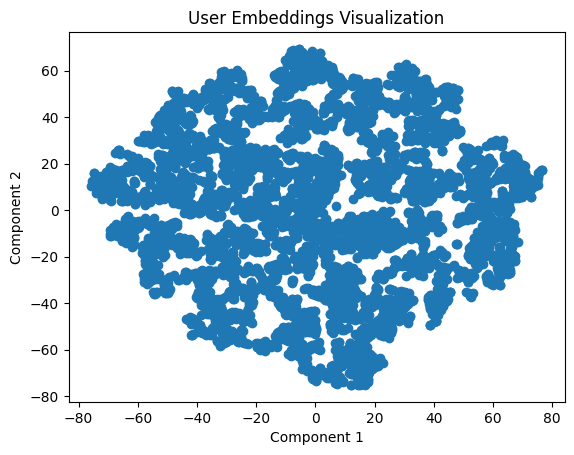

In [45]:
from sklearn.manifold import TSNE

# Use t-SNE for visualization of the user embeddings
tsne = TSNE(n_components=2, random_state=42)
user_embeddings = tsne.fit_transform(model.A_)

plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1])
plt.title('User Embeddings Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

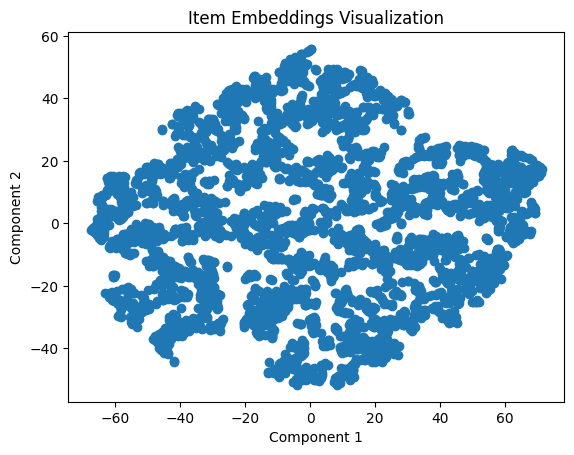

In [46]:
tsne = TSNE(n_components=2, random_state=42)
user_embeddings = tsne.fit_transform(model.B_)

plt.scatter(user_embeddings[:, 0], user_embeddings[:, 1])
plt.title('Item Embeddings Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [47]:
Predicted_matrix = np.dot(model.A_, model.B_.T)
Predicted_matrix = pd.DataFrame(Predicted_matrix + model.glob_mean_, index = Actual_matrix.index, columns = Actual_matrix.columns)
Predicted_matrix.head()

ItemId,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,Bamboozled,Bootmen,Digimon: The Movie,Get Carter,Get Carter,Meet the Parents,Requiem for a Dream,Tigerland,Two Family House,"Contender, The"
UserId,,,,,,,,,,,,,,,,,,,,,
1,4.075755,3.918417,4.345438,4.162765,4.139352,4.129491,4.270312,4.133735,4.306574,4.338863,...,3.958764,3.374313,3.634457,3.681153,3.669096,3.657909,3.453357,3.681730,3.756861,3.593539
2,4.196232,2.875320,4.698575,4.314951,4.034973,4.377418,4.636670,4.294960,4.336568,4.725169,...,3.507644,3.622180,3.342358,3.438047,3.651940,3.685607,3.351367,3.616512,4.387713,3.577485
3,4.015409,2.882127,3.515653,3.889111,3.700153,4.263697,4.089579,4.065344,3.047976,3.569489,...,2.986360,3.908598,3.500436,3.311518,3.441530,3.650778,3.441485,2.232220,4.039588,3.623232
4,5.353467,3.340073,4.972292,3.781242,4.044146,4.782192,4.600558,4.864311,4.860324,5.564777,...,3.657676,3.539745,3.356827,3.371178,3.765328,4.260104,3.314397,4.537678,3.806792,3.816869
5,3.994104,3.123177,2.908042,2.585108,2.920305,3.454779,2.926332,3.502069,2.951687,3.363905,...,2.982232,3.910867,3.448047,3.287597,3.518456,3.945950,3.651435,3.770324,3.180253,3.755662


In [48]:
def Item_cosine_similarity_mf(data = Predicted_matrix):
  data = data.T
  item_matrix = cosine_similarity(data)
  df =  pd.DataFrame(item_matrix, index=data.index, columns=data.index)
  return df

k = Item_cosine_similarity_mf()
Movie_name = "Liar Liar"

k.sort_values(by = Movie_name, ascending = False)[Movie_name][1:6]

,Liar Liar
ItemId,
"Beverly Hillbillies, The",0.999845
Bambi,0.999788
Something to Talk About,0.999777
"Browning Version, The",0.999732
"Apartment, The",0.999727


GENERATING RECOMMENDATIONS USING MATRIX FACTORIATION

In [49]:
# This function recommends Top 10 movies to a particular user: Recommendation_using_matrix_factorization(user: list like or single int)

def Recommendation_using_matrix_factorization(user, model = model, data = merged_df, Top = 10):
  dict_ = {}
  try:
    for i in user:
      top_items = model.topN(user=i, n=Top)
      dict_[i] = merged_df.loc[merged_df.MovieID.isin(top_items)]["Title"].unique()
    return dict_
  except:
      top_items = model.topN(user=user, n=Top)
      dict_[user] = merged_df.loc[merged_df.MovieID.isin(top_items)]["Title"].unique()
      return dict_

# This funtion returns five similar user with input user

def User_cosine_similarity(user, data = matrix):
  item_matrix = cosine_similarity(data)
  df =  pd.DataFrame(item_matrix, index=data.index, columns=data.index)
  return df.sort_values(by = user, ascending = False).index[:5]


# 6. Build a Recommender System User-based Pearson Correlation.

**Function to generate User feed using collaborative filtering**

In [50]:
def User_feed(user):
  feed = list([])
  rec = Recommendation_using_matrix_factorization(user = User_cosine_similarity(user))
  for key, value in rec.items():
    feed.append(value)
  return set(np.array(feed).flatten())


# Generate feed to user of ID = 1
User_feed(1)

{'Across the Sea of Time',
 'Apollo 13',
 'Beauty and the Beast',
 'Bewegte Mann, Der',
 'Bridge on the River Kwai, The',
 'Color Purple, The',
 'Forrest Gump',
 'Gambler, The (A Játékos)',
 'Glass Shield, The',
 'Gone with the Wind',
 'Grandfather, The (El Abuelo)',
 'Grateful Dead',
 'Great Escape, The',
 'Green Mile, The',
 'In the Line of Duty 2',
 "It's a Wonderful Life",
 'Light It Up',
 'Love and Other Catastrophes',
 'Marcello Mastroianni: I Remember Yes, I Remember',
 'My Fair Lady',
 'Passion in the Desert',
 'Patriot, The',
 'Pretty Woman',
 'Price Above Rubies, A',
 'Raiders of the Lost Ark',
 'Remember the Titans',
 'Sanjuro',
 'Santa with Muscles',
 "Schindler's List",
 'Shawshank Redemption, The',
 'Slipper and the Rose, The',
 'Sound of Music, The',
 'Specials, The',
 'Star Wars: Episode IV - A New Hope',
 'Titanic',
 'To Kill a Mockingbird',
 'Top Gun',
 'Trois',
 'Underworld',
 'Wide Awake',
 'Wizard of Oz, The'}

# OVERLAP

avg_perc_overlap: 0.37701899740564065


<Axes: >

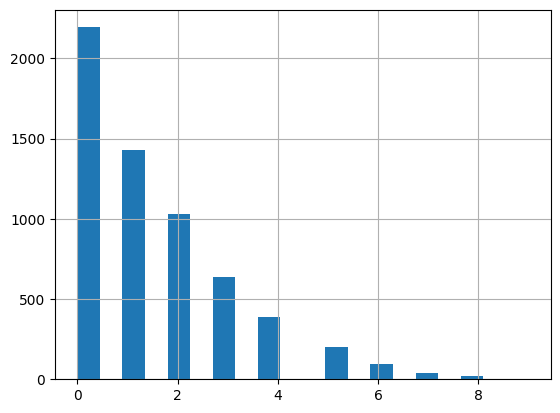

In [51]:
# Intersection of top 20 recommended movies and top 20 already seen movies by the user is being called overlap

overlap = []  # List to store the count of overlaps for each user
num_rec = []  # List to store the number of valid recommendations for each user
n = 20  # Number of top movies to consider

# Loop through each unique user in the ratings dataset
for user in ratings.UserID.unique():
    # Get the top N recommended movies for the current user
    top_items = model.topN(user=user, n=n)

    # Get the movie IDs that the current user has rated
    user_movies = ratings.loc[(ratings.UserID == user)].MovieID

    # Calculate the intersection of top recommended movies and movies the user has rated
    valid_rec = set(top_items).intersection(set(user_movies))

    # Determine the number of top-rated movies in common between recommended and already watched by the user
    _ = len(set(ratings.loc[ratings.UserID == user].sort_values(by='Rating', ascending=False).head(n).MovieID).intersection(set(valid_rec)))

    # Append the number of overlaps to the list
    overlap.append(_)

    # Append the number of valid recommendations to the list
    num_rec.append(len(valid_rec))

# Calculate and print the average percentage overlap
print('avg_perc_overlap:', np.array(overlap).mean() / np.array(num_rec).mean())

# Plot a histogram of the overlap values
pd.Series(overlap).hist(bins=20)


Our model overlapped 37% movies that means, model recommended average of 37 out of 100 movies user already watched.

This level of overlap suggests that the model effectively captures and aligns with the user’s known preferences, as it consistently recommends a substantial number of previously watched movies

#Precision @ K

avg: 0.8593226860310715


<Axes: >

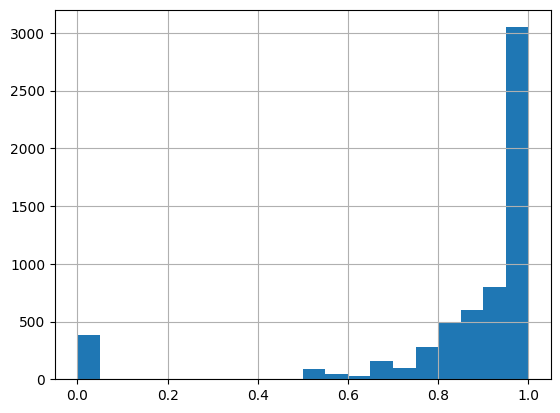

In [52]:
overlap=[]
for user in ratings.UserID.unique():
    recommendations = model.topN(user=user, n=100)
    user_movies = ratings.loc[(ratings.UserID==user)].MovieID
    valid_rec = set(recommendations).intersection(set(user_movies))
    relevant_items = ratings.loc[(ratings.UserID==user) & (ratings.Rating>=4)].MovieID
    try:
        _ = len(set(recommendations).intersection(set(relevant_items))) / len(valid_rec)
    except:
        _ = 0
    overlap.append(_)

overlap = np.array(overlap)
print('avg:', overlap.mean())
pd.Series(overlap).hist(bins=20)

The recommender system achieved a Precision@K of 85%, indicating a high level of accuracy in its recommendations. This metric reflects that 85% of the items in the top-K recommendations were relevant, aligning closely with the users' preferences.

# 7. Regression Based Recommendation System

Encoding of relavent catagorical variables

In [53]:
# one hot encoding Genres
ohe_df = pd.get_dummies(merged_df['Genres'], dtype = int)
# one hot encoding Genres
ohe_df = pd.get_dummies(merged_df['Genres'], dtype = int)
merged_df = pd.concat([merged_df.drop('Genres', axis=1), ohe_df], axis=1)
df_encoded = merged_df.copy()

# Dropping irrelavant
df_encoded.drop(columns = ["Zip-code", "Occupation_", "Occupation", "UserID", "MovieID", "Title", "Age_", "Release year"], inplace = True)

In [54]:
X = df_encoded.drop("Rating", axis = 1)
y = df_encoded.pop("Rating")

In [55]:
X.shape, y.shape

((2101763, 22), (2101763,))

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
from sklearn.ensemble import RandomForestRegressor
from  lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

model_1 = LGBMRegressor()
model_1.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 794
[LightGBM] [Info] Number of data points in the train set: 1681410, number of used features: 22
[LightGBM] [Info] Start training from score 3.582305


LGBMRegressor()

In [58]:
y_pred_1 = model_1.predict(X_test)

In [59]:
RMSE_model_1 = mean_squared_error(y_test, y_pred_1, squared=False)
RMSE_model_1

0.9100751496969585

In [60]:
# MAPE
Mape = np.mean(np.abs((y_test - y_pred_1) / y_test))
Mape

0.28094929996379303

RMSE of model on testing data is 0.9 that mean average prediction are off by 0.91 from the original ratings

How regressor model can be used for recommendation?

- Suppose we have used and movie in our dataset
- by using regressor model we can predict what perticular user will rate a perticular movie.

- for example UserId = 1 in our dataset has watched movie "Toy Story 2"(MovieID = 3114) movie and has rated this Movie = 4

- now this user have not watched movie title "To Kill a Mockingbird" (MovieID = 1207) and we want to know if user 1 will like movie or not? (how much user 1 will rate movie)
- As per feature of User and Movie our model predict user will rate movie "To Kill a Mockingbird" as 2.99. which is not very good rating.
- So like this by keeping user average as threshould if predicted rating is greater than user's average rating that movies we can recommend to a user.

In [61]:
movie_features = merged_df.drop(columns=["UserID", "Rating", "Avg_rating_user",	"Gender",	"Zip-code",	"Occupation_", "Occupation"	,"Age_",	"Title",	"Release year"]).set_index("MovieID")
user_features = merged_df[["UserID", "Avg_rating_user",	"Gender"]].set_index("UserID")

# Recommendation Using Light GBM Regressor

In [62]:
def predict_rating(user_id, movie_id):
  movie_dict_1 = {'Avg_rating_movie': movie_features.loc[movie_id][["Avg_rating_movie",	"Avg_rating_movie_count"]].drop_duplicates().values[0][0],
  'Avg_rating_movie_count': movie_features.loc[movie_id][["Avg_rating_movie",	"Avg_rating_movie_count"]].drop_duplicates().values[0][1]}

  user_dict = {"Avg_rating_user": user_features.loc[1][["Avg_rating_user",	"Gender"]].drop_duplicates().values[0][0],
  "Gender": user_features.loc[user_id][["Avg_rating_user",	"Gender"]].drop_duplicates().values[0][1]}

  movie_dict_2 = movie_features.loc[movie_id].drop(columns=["Avg_rating_movie",	"Avg_rating_movie_count"]).drop_duplicates().sum(axis = 0).to_dict()

  movie_dict_1.update(user_dict)
  movie_dict_1.update(movie_dict_2)

  # panda dataframe
  dk = pd.DataFrame(movie_dict_1, index = [0])
  dk = dk[['Avg_rating_movie', 'Avg_rating_movie_count', 'Avg_rating_user',
        'Gender', 'Action', 'Adventure', 'Animation', "Children's", "Comedy",
        'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
        'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
        'Western']]

  return model_1.predict(dk)[0]

Predicting Top 5 recommendations for user 1

In [63]:
ratings = []
MovieID = []
for i in range(1,20):
  MovieID.append(i)
  ratings.append(predict_rating(1, i))

mask = np.array(ratings).argsort()[::-1][:5]
MovieID = np.array(MovieID)[mask]
ratings = np.array(ratings)[mask]

merged_df.loc[merged_df.MovieID.isin(MovieID)]["Title"].unique()

array(['Toy Story', 'Heat', 'Casino', 'Sense and Sensibility',
       'American President, The'], dtype=object)

Questionnaire:

Q.1 Users of which age group have watched and rated the most number of movies?


In [64]:
Q1 = pd.DataFrame(merged_df.groupby("Age_").nunique()["MovieID"].sort_values(ascending=False))
Q1["Rating_counts"] = merged_df.groupby("Age_").count()["Rating"].sort_values(ascending=False).values
Q1.rename(columns = {"MovieID": "Unique Movies Count"})

,Unique Movies Count,Rating_counts
Age_,,
25-34,3506,831323
35-44,3444,417524
18-24,3390,391834
45-49,3286,173666
50-55,3256,149780
56+,2912,78816
Under 18,2650,58820


Ans: Age group 25-34 have watched and rated the most number of movies.

Q.2 Users belonging to which profession have watched and rated the most movies?

In [65]:
Q2 = pd.DataFrame(merged_df.groupby("Occupation_").nunique()["MovieID"].sort_values(ascending=False))
Q2["Rating_counts"] = merged_df.groupby("Occupation_").count()["Rating"].sort_values(ascending=False).values
Q2.rename(columns = {"MovieID": "Unique Movies Count"})

,Unique Movies Count,Rating_counts
Occupation_,,
other,3446,277740
college/grad student,3360,271872
writer,3329,221076
executive/managerial,3268,175505
academic/educator,3217,160668
artist,3144,125215
self-employed,3122,122861
technician/engineer,3087,104046
doctor/health care,3009,103075


Ans: profession Others(not mentioned) and college/grad student have watched and rated the most number of movies.


Q.3 Most of the users in our dataset who’ve rated the movies are Male. (T/F)


In [66]:
merged_df["Gender"].value_counts()

,count
Gender,
1,1595854
0,505909


Ans: True

Q4. Most of the movies present in our dataset were released in which decade?
70s b. 90s c. 50s d.80s

Ans: 90s

In [67]:
merged_df["Release year"].value_counts()

,count
Release year,
90s,1193543
80s,494374
70s,172507
60s,94325
50s,73653
40s,43091
30s,28248
20s,2022


Ans: Most of the movies present in our dataset were released in 90s



Q.5 The movie with maximum no. of ratings is ___.

In [68]:
merged_df.groupby("Title")["Rating"].count().sort_values(ascending=False).head(1)

,Rating
Title,
Star Wars: Episode V - The Empire Strikes Back,14950


Ans: The movie with maximum no. of ratings is 14950.

Q.6 Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach.


In [69]:
top_3 = Item_cosine_similarity(data = matrix).sort_values(by = "Liar Liar", ascending = False)[1:4].index
top_3

Index(['Mrs. Doubtfire', 'Ace Ventura: Pet Detective', 'Dumb & Dumber'], dtype='object', name='Title')

Ans: 'Mrs. Doubtfire', 'Ace Ventura: Pet Detective', 'Dumb & Dumber'

Q.7 On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.



Ans: On the basis of approach, Collaborative Filtering methods can be classified into User based and Item based

- **User-based Collaborative Filtering:** This method predicts a user’s rating of an item, based on the ratings given by similar users.

- **Item-based Collaborative Filtering:** This method predicts a user’s rating of an item, based on the user’s ratings of similar items.

Q: 8 Pearson Correlation ranges between _ to _ whereas, Cosine Similarity belongs to the interval between _ to _.

Ans: Pearson Correlation ranges between -1 to 1 whereas, Cosine Similarity belongs to the interval between **0 to 1 when dealing with Non negative vectors**

Q.9 Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.

Ans: RMSE = 1.35, MAPE = MAPE: 37.818



Q. 10 Give the sparse ‘row’ matrix representation for the following dense matrix -

[[1 0]

[3 7]]

Ans:

(0, 0) 1

(1, 0) 3

(1, 1) 7

In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
!apt-get install texlive-xetex texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra
!apt-get install pandoc
!pip install pypandoc

In [ ]:
!jupyter nbconvert --to pdf /content/Zee_Recommender_Systems_hp.ipynb